# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Импорт библиотек ⬇

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

warnings.filterwarnings('ignore')

## Подготовка данных

### Анализ данных

In [2]:
autos_data = pd.read_csv('/datasets/autos.csv')
display(autos_data.info())
autos_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
autos_data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


    Оценим количество пропусков по каждому критерию.

In [4]:
autos_data.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
Repaired             0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

    Столбцы VehicleType, Gearbox, FuelType и Repaired имеют пропуски. Изучим, какие данные есть в каждом столбце.

In [5]:
def show_rows(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].unique())

In [6]:
show_rows(autos_data)

Уникальные значения столбца DateCrawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
Уникальные значения столбца Price
[  480 18300  9800 ... 12395 18429 10985]
Уникальные значения столбца VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения столбца RegistrationYear
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290

    В столбце RegistrationYear существуют некорректные значения года регистрации.
    В столбце RegistrationMonth отсутсвует месяц регистрации.
    В столбце Power присутвует некорректное значение мощности.

    К значимым признакам отнесем следующие столбцы:

    1)VehicleType. Тип машины определяет ее функционал. Чем больше возможносей у машины, тем выше цена.
    2)Gearbox. Наличие автоматической коробки передач повышает стоимость машины из-за сложности конструкции.
    3)Power. Мощность в лоашдиных силах (далее л.с.) напрямую влияют на цену.
    4)Kilometer. Имеет обратно пропорциональную зависиммость от цены. Чем больше километров проехала машина, тем меньше ее
    надежность и соответсвенно цена.
    5)FuelType. Тип топлива определяет конструкцию двигателя внутреннего сгорания.
    6)Brand. Концерн/компания, которая создала автомобиль показывает качество и надежность автомобиля.
    7)Repaired. Машины, которые побывали в дорожно-транспортных проишествиях означает, что машина подвергалась изменениям и ее надежность ниже.
    8)RegistrationYear. Год регистрации определяет сколько уже лет машина на ходу. соответвенно, чем больше возраст, тем
    меньше цена.
    9)Model. В купе с типом машины и брендом може влиять на популярность у покупателей.

    Остальные столбцы для модели не требуются, так как не влияют на стоимость.

### Преобрадотка данных

Сократим дата фрейм до нужных столбцов.

In [7]:
filtred_autos_data = autos_data[['VehicleType', 
                         'Gearbox', 
                         'Power',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'Repaired',
                         'RegistrationYear',
                         'Model',
                         'Price']]
filtred_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   Gearbox           334536 non-null  object
 2   Power             354369 non-null  int64 
 3   Kilometer         354369 non-null  int64 
 4   FuelType          321474 non-null  object
 5   Brand             354369 non-null  object
 6   Repaired          283215 non-null  object
 7   RegistrationYear  354369 non-null  int64 
 8   Model             334664 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


    Столбцы, требующие обработки:
        
        1)VehicleType. Восстановим пропущенные значения по популярному типу из столбца Brand.
        2)Gearbox. Для всех NaN установим значение 'manual'.
        3)Power. Скоректируем на основе реальных значений в машинах. Иметь 1 л.с. или 15000 л.с. для машины на данный момент
        нереально.
        4)FuelType. Восстановим пропущенные значения по популярному типу из столбца Brand.
        5)Repaired. Для всех NaN установим значение 'yes'.
        6)RegistrationYear. Скоректируем на основе реальных значений в машинах.
        7)Model. Для всех NaN установим значение 'unknown'.

    Проверим наполнение целевого признака Price.

In [8]:
filtred_autos_data['Price'].value_counts()

Price
0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: count, Length: 3731, dtype: int64

    Видно, что существует 10772 записи без цены. Удалим их и проверим распределение цены на гистограмме.

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

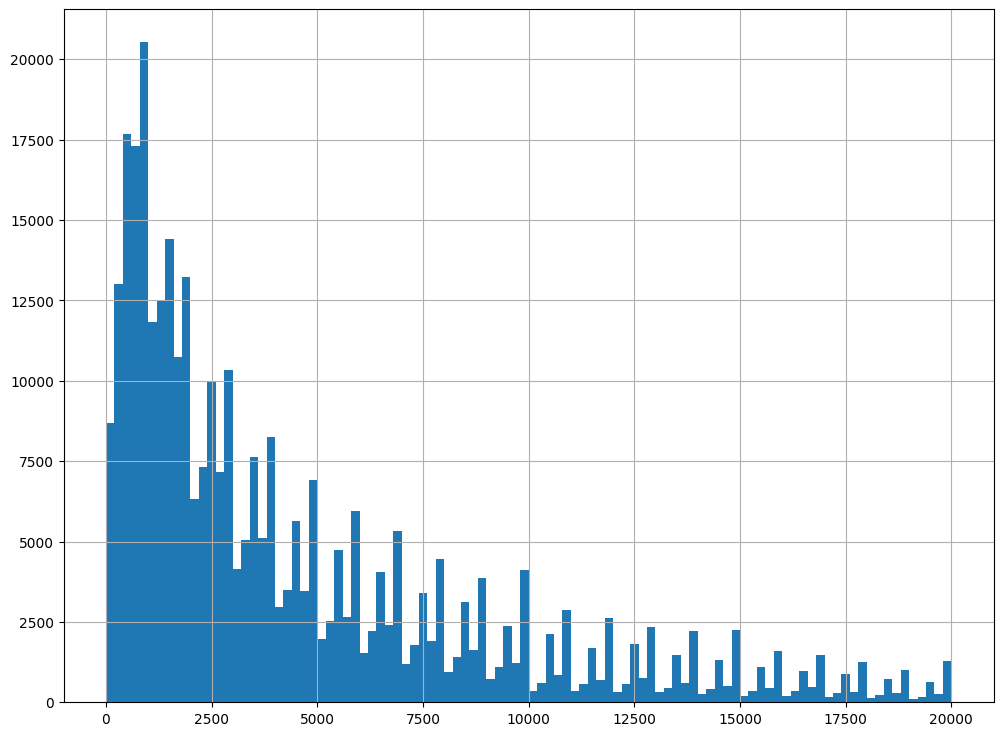

In [9]:
filtred_autos_data = filtred_autos_data.query('Price > 0')
filtred_autos_data['Price'].hist(bins=100, figsize=(12,9))
filtred_autos_data['Price'].describe()

    Выделим квантили 5% и 80%

In [10]:
filtred_autos_data['Price'].quantile([.05, 0.8])

0.05     350.0
0.80    7800.0
Name: Price, dtype: float64

    Стоимость 350 евро примерно равно 28000 рублей. Это минимальная цена для продажи поддержанного авто. Выбор 80% квантиль обоснован большими выбросами после 7500 евро.

In [11]:
filtred_autos_data = filtred_autos_data
filtred_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343597 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       309847 non-null  object
 1   Gearbox           326242 non-null  object
 2   Power             343597 non-null  int64 
 3   Kilometer         343597 non-null  int64 
 4   FuelType          314138 non-null  object
 5   Brand             343597 non-null  object
 6   Repaired          277731 non-null  object
 7   RegistrationYear  343597 non-null  int64 
 8   Model             326076 non-null  object
 9   Price             343597 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 28.8+ MB


    Проверим значения столбца RegistrationYear на гистограмме.

count    343597.000000
mean       2004.089797
std          78.413225
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

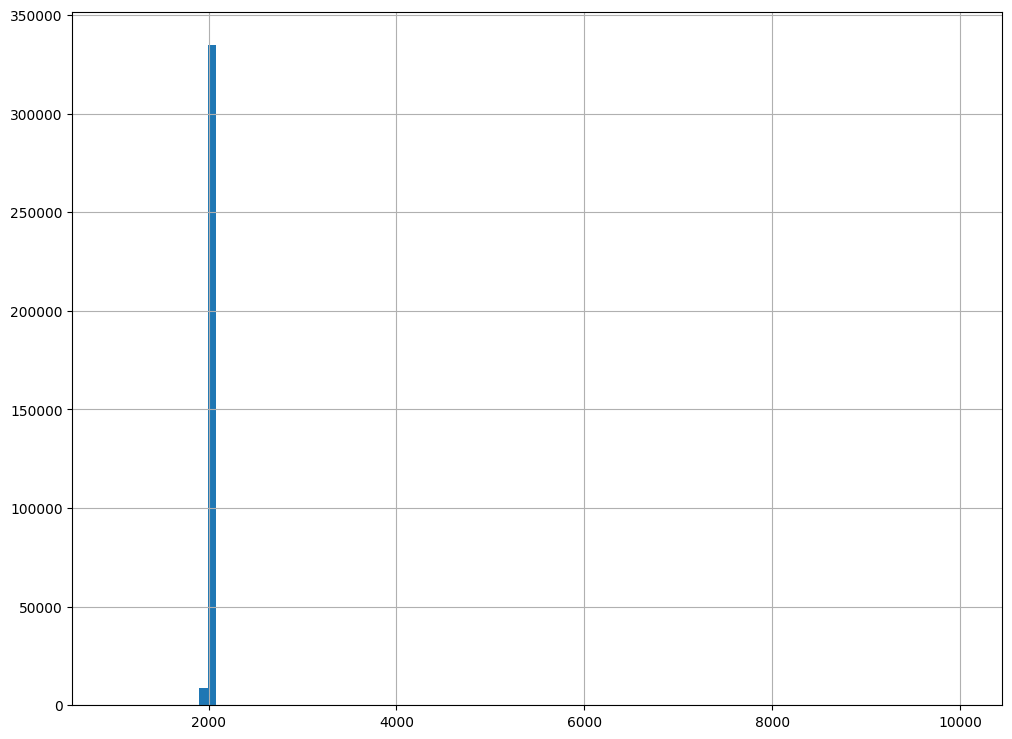

In [12]:
filtred_autos_data['RegistrationYear'].hist(bins=100, figsize=(12,9))
filtred_autos_data['RegistrationYear'].describe()

    В годе регистрации наблюдаются выбросы. Отсечем правые выбросы, узнав максимальную дату скачивания анкеты автомобиля.

In [13]:
date = pd.to_datetime(autos_data['DateCrawled'])
date.max()

Timestamp('2016-04-07 14:36:58')

    Даты регистрации после 2016 года некорректны и машины появились не раньше 1900 года. Отсечем ненужные года и промотрим
    левые выбросы.

count    329765.000000
mean       2002.593583
std           6.927865
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

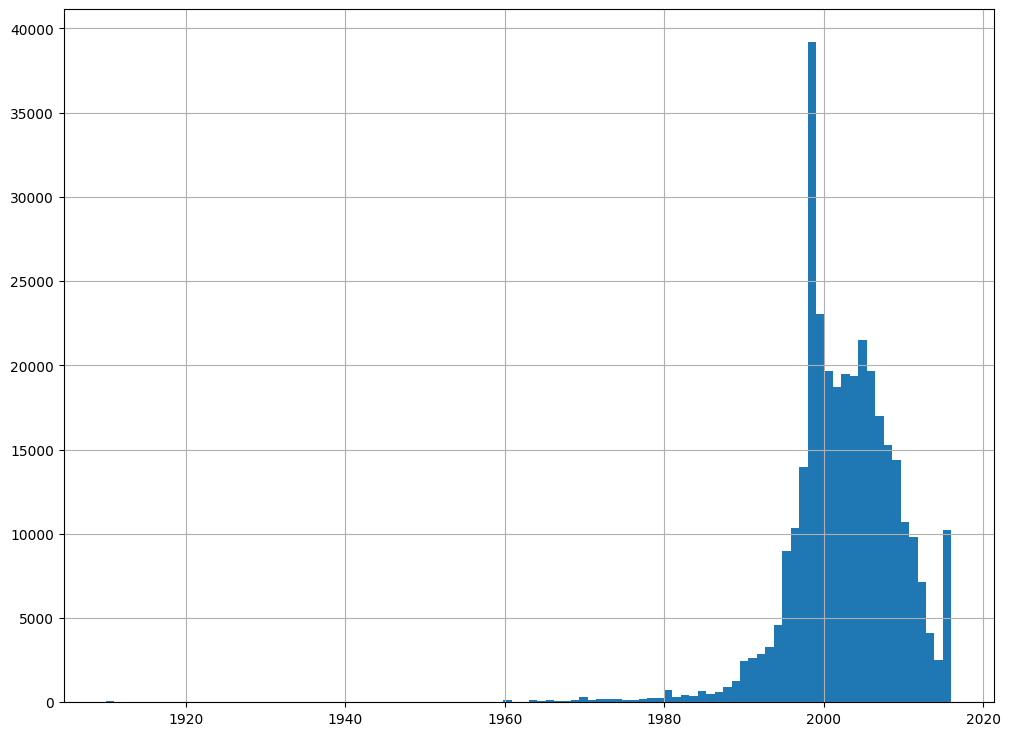

In [14]:
filtred_autos_data = filtred_autos_data.query('1899 < RegistrationYear < 2017')
filtred_autos_data['RegistrationYear'].hist(bins=100, figsize=(12,9))
filtred_autos_data['RegistrationYear'].describe()

    По левой части гистограммы видно, что адекватно использовать левую границу в 1960 год, так как это старые, но возможно
    еще работающие машины.

count    329478.000000
mean       2002.646426
std           6.674531
min        1960.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

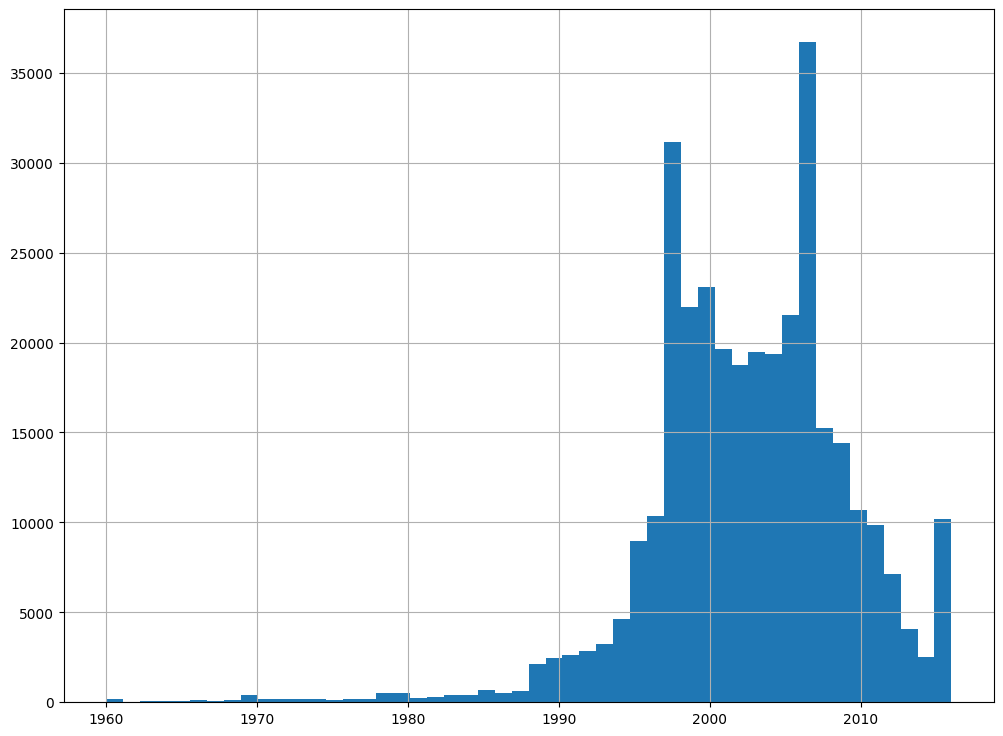

In [15]:
filtred_autos_data = filtred_autos_data.query('1959 < RegistrationYear < 2017')
filtred_autos_data['RegistrationYear'].hist(bins=50, figsize=(12,9))
filtred_autos_data['RegistrationYear'].describe()

    Проведем замену NaN в Gearbox, Repaired, Model.

In [16]:
filtred_autos_data.fillna({'Gearbox':'manual', 
                           'Repaired':'yes',
                           'Model':'unknown'},
                          inplace=True)
filtred_autos_data.isna().mean()

VehicleType         0.060389
Gearbox             0.000000
Power               0.000000
Kilometer           0.000000
FuelType            0.073161
Brand               0.000000
Repaired            0.000000
RegistrationYear    0.000000
Model               0.000000
Price               0.000000
dtype: float64

    Оценим количество пропущенных значений относительно всех значений в столбце VehicleType

In [17]:
display(filtred_autos_data['VehicleType'].value_counts())
filtred_autos_data['VehicleType'].isna().sum()

VehicleType
sedan          89298
small          77986
wagon          63692
bus            28337
convertible    19844
coupe          15613
suv            11760
other           3051
Name: count, dtype: int64

19897

    Выполним замену NaN в соотвествии с популярным типом кузова для каждого бренда.

In [18]:
vehicle_type_pivot_table = filtred_autos_data.pivot_table(index=['VehicleType'], 
                                                          columns=['Brand'],
                                                          values=['Price'],
                                                          aggfunc=['count'])
display(vehicle_type_pivot_table)
filtred_autos_data[filtred_autos_data['Brand'] == 'alfa_romeo']['VehicleType'].value_counts()

count                                                       
                 Price                                                       
Brand       alfa_romeo     audi      bmw chevrolet chrysler citroen  dacia   
VehicleType                                                                  
bus                NaN     10.0      6.0     156.0    415.0  1251.0   50.0  \
convertible      177.0   1612.0   3195.0      17.0    228.0   110.0    NaN   
coupe            225.0   1464.0   3679.0      88.0     47.0   148.0    NaN   
other             12.0    106.0    222.0      41.0      9.0   112.0    6.0   
sedan            912.0  10676.0  17219.0     222.0    276.0   688.0  100.0   
small            235.0   1536.0    437.0     580.0     12.0  1569.0  221.0   
suv                NaN    177.0    805.0     373.0     23.0    36.0  214.0   
wagon            451.0  10825.0   7763.0     105.0    241.0   617.0  251.0   

                                     ...                           
                                     ...                           
Brand       daewoo daihatsu    fiat  ...    seat   skoda   smart   
VehicleType                          ...                           
bus           27.0     34.0   818.0  ...   610.0   231.0     1.0  \
convertible    1.0     17.0   505.0  ...     NaN     4.0  1126.0   
coupe          8.0      NaN   168.0  ...    84.0     8.0   338.0   
other          5.0     10.0   177.0  ...    62.0    26.0     9.0   
sedan        105.0     47.0   875.0  ...  1737.0   904.0    28.0   
small        265.0    512.0  5186.0  ...  3060.0  1115.0  3232.0   
suv            1.0     46.0    24.0  ...     4.0   173.0     NaN   
wagon         46.0     16.0   443.0  ...   387.0  2684.0     9.0   

                                                                             
                                                                             
Brand       sonstige_autos subaru suzuki  toyota trabant volkswagen   volvo  
VehicleType                                                                  
bus                  183.0   17.0   27.0   446.0     NaN     9387.0     NaN  
convertible          315.0    1.0   35.0    63.0    36.0     2886.0    75.0  
coupe                217.0    8.0    7.0   222.0     2.0     1725.0    67.0  
other                207.0    6.0   14.0    19.0     5.0      720.0     5.0  
sedan                430.0  164.0  178.0   887.0   198.0    19294.0   633.0  
small                234.0  117.0  967.0  1580.0    54.0    17973.0     7.0  
suv                  412.0   59.0  743.0   438.0     1.0     1304.0   218.0  
wagon                122.0  292.0   87.0   568.0    70.0    12372.0  1934.0  

[8 rows x 40 columns]

VehicleType
sedan          912
wagon          451
small          235
coupe          225
convertible    177
other           12
Name: count, dtype: int64

In [19]:
vehicle_type_pivot_table = vehicle_type_pivot_table['count']['Price']
vehicle_type_pivot_table

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,10.0,6.0,156.0,415.0,1251.0,50.0,27.0,34.0,818.0,...,610.0,231.0,1.0,183.0,17.0,27.0,446.0,NaN,9387.0,NaN
convertible,177.0,1612.0,3195.0,17.0,228.0,110.0,NaN,1.0,17.0,505.0,...,NaN,4.0,1126.0,315.0,1.0,35.0,63.0,36.0,2886.0,75.0
coupe,225.0,1464.0,3679.0,88.0,47.0,148.0,NaN,8.0,NaN,168.0,...,84.0,8.0,338.0,217.0,8.0,7.0,222.0,2.0,1725.0,67.0
other,12.0,106.0,222.0,41.0,9.0,112.0,6.0,5.0,10.0,177.0,...,62.0,26.0,9.0,207.0,6.0,14.0,19.0,5.0,720.0,5.0
sedan,912.0,10676.0,17219.0,222.0,276.0,688.0,100.0,105.0,47.0,875.0,...,1737.0,904.0,28.0,430.0,164.0,178.0,887.0,198.0,19294.0,633.0
small,235.0,1536.0,437.0,580.0,12.0,1569.0,221.0,265.0,512.0,5186.0,...,3060.0,1115.0,3232.0,234.0,117.0,967.0,1580.0,54.0,17973.0,7.0
suv,NaN,177.0,805.0,373.0,23.0,36.0,214.0,1.0,46.0,24.0,...,4.0,173.0,NaN,412.0,59.0,743.0,438.0,1.0,1304.0,218.0
wagon,451.0,10825.0,7763.0,105.0,241.0,617.0,251.0,46.0,16.0,443.0,...,387.0,2684.0,9.0,122.0,292.0,87.0,568.0,70.0,12372.0,1934.0


    Заполним словарь брендов и популярных типов машин и заполним пропуски по столбцу VehicleType.

In [20]:
filtred_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 329478 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       309581 non-null  object
 1   Gearbox           329478 non-null  object
 2   Power             329478 non-null  int64 
 3   Kilometer         329478 non-null  int64 
 4   FuelType          305373 non-null  object
 5   Brand             329478 non-null  object
 6   Repaired          329478 non-null  object
 7   RegistrationYear  329478 non-null  int64 
 8   Model             329478 non-null  object
 9   Price             329478 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.7+ MB


In [21]:
filtred_autos_data.fillna({'VehicleType':0},inplace=True)

def fillna_by_brand(row, row_number, vehicle_type_pivot_table):
    brand = row[5]
    fill_value = row[row_number]
    if row[row_number] == 0:
        fill_value = vehicle_type_pivot_table[brand].idxmax()
    return fill_value

filtred_autos_data['VehicleType'] = filtred_autos_data.apply(
                                fillna_by_brand, 
                                args=[0, vehicle_type_pivot_table],
                                axis=1)
display(filtred_autos_data['VehicleType'].isna().sum())
filtred_autos_data['VehicleType'].value_counts()

0

VehicleType
sedan          98712
small          86610
wagon          65269
bus            28409
convertible    19902
coupe          15613
suv            11912
other           3051
Name: count, dtype: int64

    Также аполним пропуски в FuelType

In [22]:
filtred_autos_data['FuelType'].value_counts()
fuel_type_pivot_table = filtred_autos_data.pivot_table(index=['FuelType'], 
                                                          columns=['Brand'],
                                                          values=['Price'],
                                                          aggfunc=['count'])
fuel_type_pivot_table = fuel_type_pivot_table['count']['Price']
display(fuel_type_pivot_table)

filtred_autos_data.fillna({'FuelType':0},inplace=True)

filtred_autos_data['FuelType'] = filtred_autos_data.apply(
                                fillna_by_brand, 
                                args=[4, vehicle_type_pivot_table],
                                axis=1)
display(filtred_autos_data['FuelType'].isna().sum())
filtred_autos_data['FuelType'].value_counts()

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
FuelType,,,,,,,,,,,,,,,,,,,,,
cng,NaN,1.0,10.0,4.0,NaN,7.0,2.0,NaN,NaN,67.0,...,2.0,6.0,2.0,7.0,2.0,NaN,NaN,NaN,181.0,20.0
electric,NaN,2.0,3.0,NaN,NaN,1.0,NaN,NaN,1.0,4.0,...,NaN,NaN,7.0,21.0,NaN,NaN,NaN,NaN,4.0,NaN
gasoline,589.0,12027.0,11788.0,235.0,365.0,1545.0,204.0,1.0,4.0,1407.0,...,1616.0,1892.0,842.0,431.0,41.0,226.0,969.0,1.0,24485.0,1036.0
hybrid,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,1.0,NaN,1.0,19.0,NaN,NaN,125.0,1.0,5.0,NaN
lpg,33.0,443.0,725.0,176.0,93.0,68.0,52.0,23.0,6.0,67.0,...,62.0,51.0,3.0,121.0,29.0,22.0,25.0,NaN,519.0,108.0
other,NaN,3.0,7.0,1.0,NaN,3.0,NaN,1.0,NaN,4.0,...,NaN,NaN,1.0,29.0,1.0,1.0,NaN,36.0,22.0,3.0
petrol,1372.0,13553.0,20069.0,1129.0,771.0,2873.0,562.0,425.0,662.0,6536.0,...,4237.0,3120.0,3856.0,1377.0,573.0,1781.0,3082.0,276.0,40175.0,1714.0


0

FuelType
petrol         204515
gasoline        94833
sedan           11116
small           10493
lpg              5023
wagon            2127
cng               533
hybrid            220
suv               202
other             162
bus                94
electric           87
convertible        73
Name: count, dtype: int64

In [23]:
filtred_autos_data.isna().mean()

VehicleType         0.0
Gearbox             0.0
Power               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
Repaired            0.0
RegistrationYear    0.0
Model               0.0
Price               0.0
dtype: float64

    Пропуски убраны. Остались некорректные значения в столбце Power.

count    329478.000000
mean        111.959214
std         184.883693
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

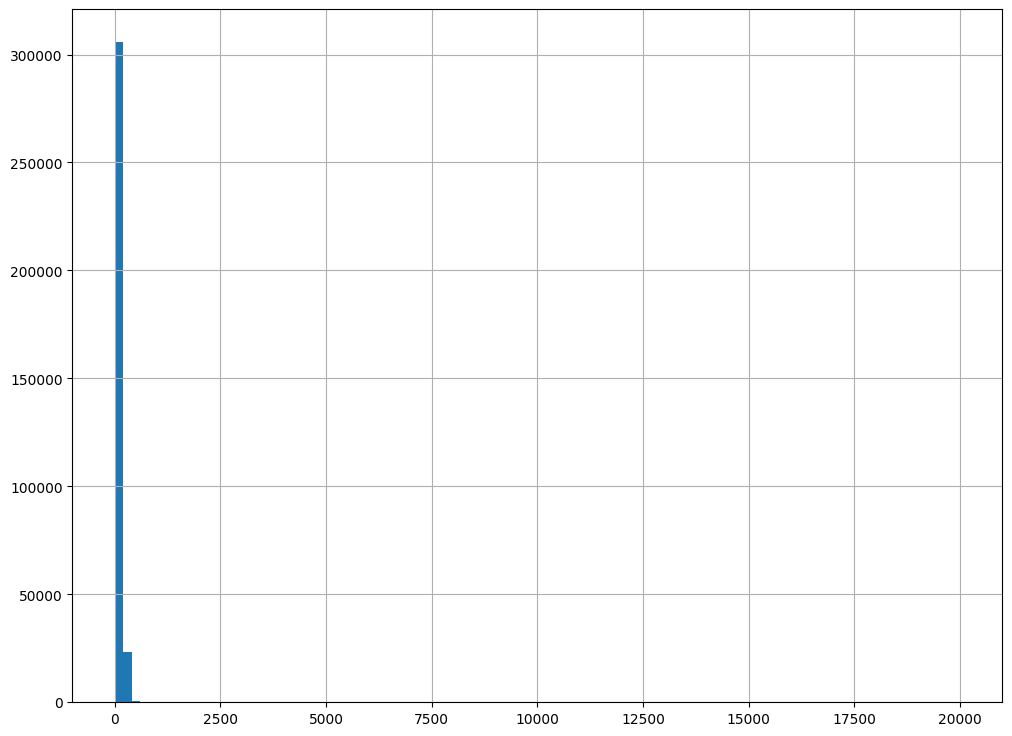

In [24]:
filtred_autos_data['Power'].hist(bins=100, figsize=(12,9))
filtred_autos_data['Power'].describe()

    Раброс очень сильный, усечем выбросы больше 1000 л.с.

count    329217.000000
mean        108.743926
std          63.315293
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max        1000.000000
Name: Power, dtype: float64

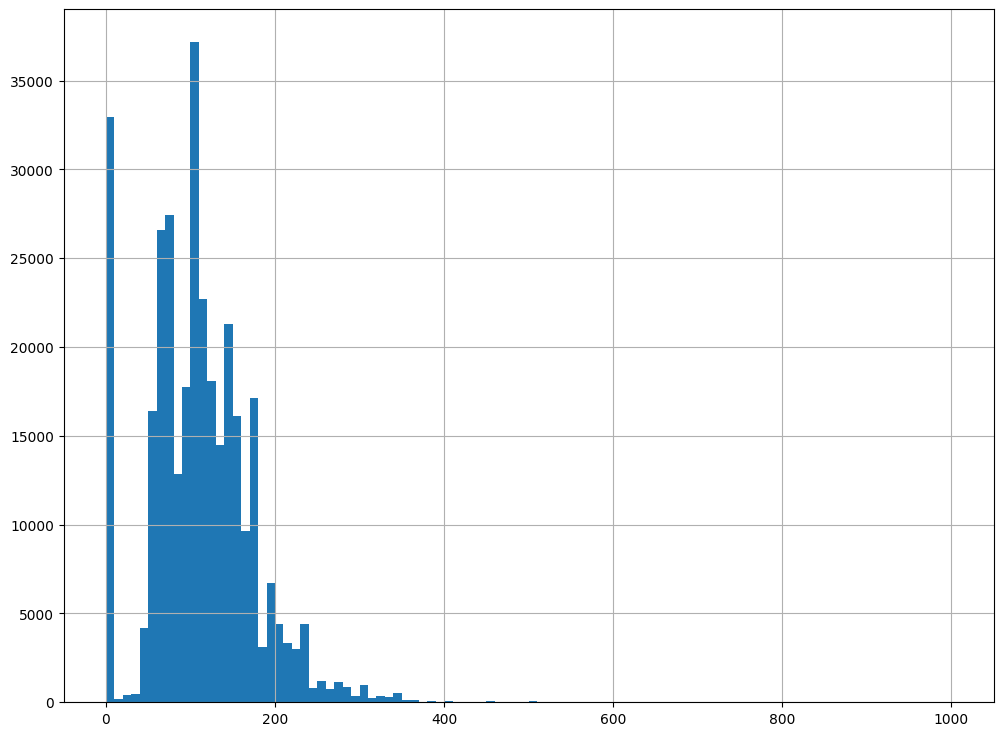

In [25]:
filtred_autos_data = filtred_autos_data.query('Power < 1001')
filtred_autos_data['Power'].hist(bins=100, figsize=(12,9))
filtred_autos_data['Power'].describe()

    Из графика видно, что многие машины имеют мощность 0. Эти строки не подлежат восстановлению и будут удалены. По правому
    отсечению выбреме границу в 400 л.с

count    296091.000000
mean        120.218963
std          52.645441
min           1.000000
25%          75.000000
50%         110.000000
75%         150.000000
max         400.000000
Name: Power, dtype: float64

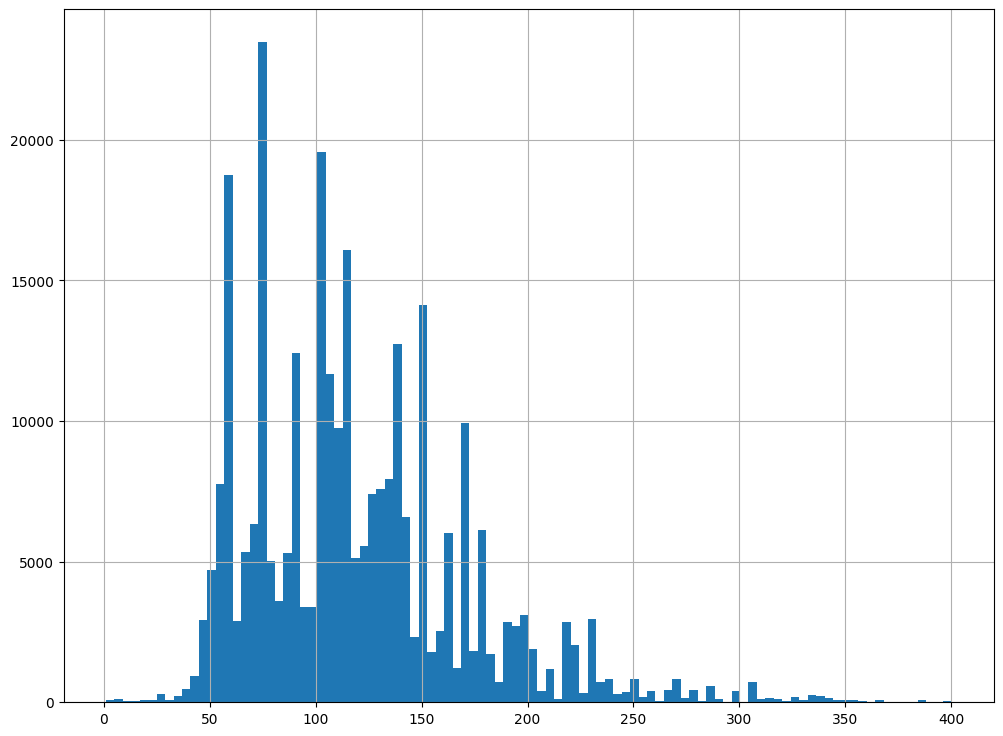

In [26]:
filtred_autos_data = filtred_autos_data.query('0 < Power < 401')
filtred_autos_data['Power'].hist(bins=100, figsize=(12,9))
filtred_autos_data['Power'].describe()

    Следующими границами выберем 25 и 350 л.с.

count    295191.000000
mean        120.006101
std          51.619754
min          25.000000
25%          75.000000
50%         110.000000
75%         150.000000
max         350.000000
Name: Power, dtype: float64

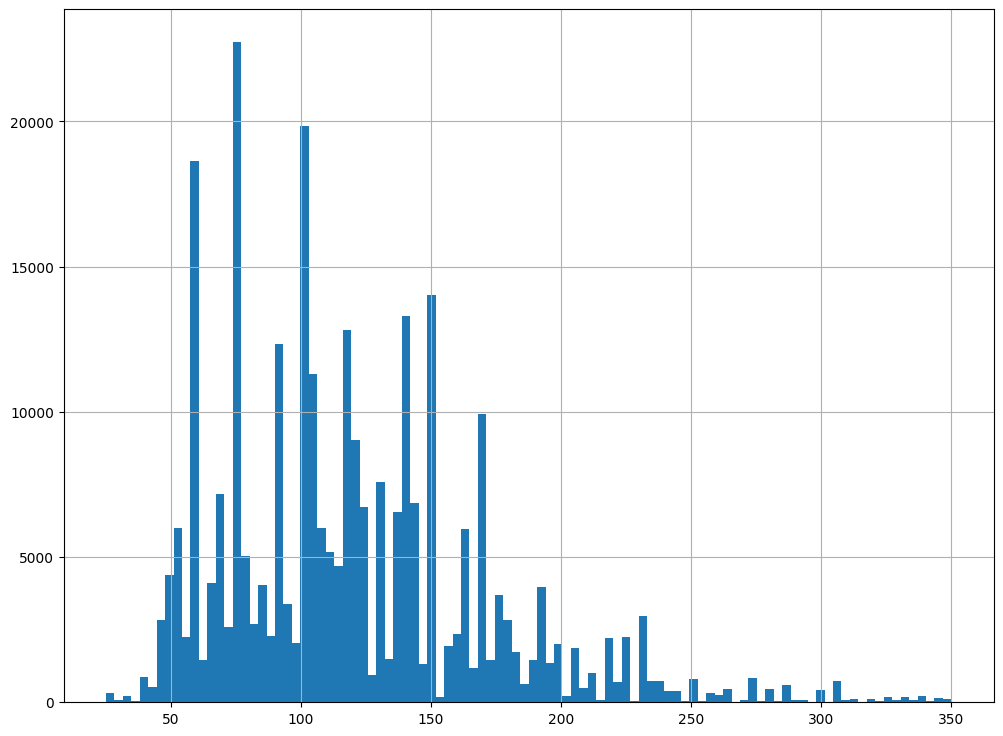

In [27]:
good_autos_data = filtred_autos_data.query('24 < Power < 351')
good_autos_data['Power'].hist(bins=100, figsize=(12,9))
good_autos_data['Power'].describe()

In [28]:
good_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295191 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       295191 non-null  object
 1   Gearbox           295191 non-null  object
 2   Power             295191 non-null  int64 
 3   Kilometer         295191 non-null  int64 
 4   FuelType          295191 non-null  object
 5   Brand             295191 non-null  object
 6   Repaired          295191 non-null  object
 7   RegistrationYear  295191 non-null  int64 
 8   Model             295191 non-null  object
 9   Price             295191 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 24.8+ MB


    Проведем замену столбцов Gearbox и Repaired на булев тип

        1) IsManualGearbox. 1(manual) - означает механическую коробку передач. 0(auto) - автоматическую.
        2) IsNotRepaired. 1(yes) - означает машину без ремонта. 0(no) - с ремонтом.


In [29]:
good_autos_data['IsManualGearbox'] = 0
good_autos_data.loc[good_autos_data['Gearbox'] == 'manual', 'IsManualGearbox'] = 1
display(good_autos_data['IsManualGearbox'].value_counts())
good_autos_data['Gearbox'].value_counts()

IsManualGearbox
1    237054
0     58137
Name: count, dtype: int64

Gearbox
manual    237054
auto       58137
Name: count, dtype: int64

In [30]:
good_autos_data['IsRepaired'] = 0
good_autos_data.loc[good_autos_data['Repaired'] == 'yes', 'IsRepaired'] = 1
display(good_autos_data['IsRepaired'].value_counts())
good_autos_data['Repaired'].value_counts()

IsRepaired
0    223685
1     71506
Name: count, dtype: int64

Repaired
no     223685
yes     71506
Name: count, dtype: int64

    Удалим ненужные столбцы и уменьшим размерность хранения типа для ускорения работы с дата фреймом.

In [31]:
good_autos_data.drop(['Repaired','Gearbox'], inplace=True, axis=1)
good_autos_data['IsRepaired'] = pd.to_numeric(good_autos_data['IsRepaired'], downcast='integer')
good_autos_data['IsManualGearbox'] = pd.to_numeric(good_autos_data['IsManualGearbox'], downcast='integer')
good_autos_data['RegistrationYear'] = pd.to_numeric(good_autos_data['RegistrationYear'], downcast='integer')
good_autos_data['Power'] = pd.to_numeric(good_autos_data['Power'], downcast='integer')
good_autos_data['Kilometer'] = pd.to_numeric(good_autos_data['Kilometer'], downcast='integer')
good_autos_data['Price'] = pd.to_numeric(good_autos_data['Price'], downcast='integer')
good_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295191 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       295191 non-null  object
 1   Power             295191 non-null  int16 
 2   Kilometer         295191 non-null  int32 
 3   FuelType          295191 non-null  object
 4   Brand             295191 non-null  object
 5   RegistrationYear  295191 non-null  int16 
 6   Model             295191 non-null  object
 7   Price             295191 non-null  int16 
 8   IsManualGearbox   295191 non-null  int8  
 9   IsRepaired        295191 non-null  int8  
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 14.6+ MB


In [32]:
print('Уменьшение использования памяти на {:.2%}'.format(1 - 11.0/43.3))

Уменьшение использования памяти на 74.60%


### Вывод:

    1) Была изучена таблица данных.
    2) Выведены аномальные и пропущенные значения.
    3) Отобраны небходимые столбцы для обучения модели.
    4) Заполнены пропуски в столбцах и удалены некорректные значения.
    5) Заменены два категориальных признака на численные.
    6) Выигрыш в памяти составляет 75%, что ускорит обращение к памяти при обучении модели.

## Обучение моделей

    Возьмём следующие модели для обучения:
    
        1) LinearRegression
        2) Ridge
        3) CatBoostRegressor
        4) LGBMRegressor

    В качестве метрики для всех моделей будем использовать MSE и в финальной таблице переведем в RMSE. Качество моделей
    будем проверять на кроссвалидации.

    Подготовим три типа признаков для кроссвалидации:

-Неизмененные. original_features.

-Закодированные методом OHE. ohe_features.

-Закодированные методом OE. ordinal_features.

#Неизмененные признаки
original_features = good_autos_data.drop('Price', axis=1)

#Прямое кодирование
encoder = OrdinalEncoder()
cat_columns = ['VehicleType','FuelType','Brand','Model']
cat_features = original_features[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)
ordinal_features = original_features.copy()
for column in cat_columns:
    ordinal_features[column] = cat_features[column]

#OHE кодирование
ohe_features = pd.get_dummies(original_features, drop_first=True)

#Целевой признак
target = good_autos_data['Price']


In [33]:

features = good_autos_data.drop(['Price'], axis=1)
target = good_autos_data['Price']

original_features = good_autos_data.drop('Price', axis=1).astype('bool')

ohe_features = pd.get_dummies(original_features, drop_first=True)

#создаем обучающую,валидационную и тестовую выборки
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.2, 
                                                                              random_state=12345)
features_train, features_test, target_train, target_test = train_test_split(features_train,
                                                                            target_train, 
                                                                            random_state=12345)

# создаем копию чистых данных, чтобы их не исказить.
ohe_features_train = features_train.copy()
ohe_features_valid = features_train.copy()
ohe_features_test = features_test.copy()

# сохраняем список категориальных признаков
cat_features = features_train.select_dtypes(include='object').columns.to_list()


# проведем иницаилизацию OHE-енкодера
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучим энкодер по тренировочным данным
encoder_ohe.fit(ohe_features_train[ohe_features])

# добавим закодированные признаки и удалим колонки с категориальными признаками
ohe_features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(ohe_features_train[ohe_features])
ohe_features_valid[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(ohe_features_valid[ohe_features])
ohe_features_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(ohe_features_test[ohe_features])

ohe_features_train = ohe_features_train.drop(ohe_features, axis=1)
ohe_features_valid = ohe_features_valid.drop(ohe_features, axis=1)
ohe_features_test = ohe_features_test.drop(ohe_features, axis=1)

In [34]:
oe_features_train = features_train.copy()
oe_features_valid = features_valid.copy()
oe_features_test = features_test.copy()


oe_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe_encoder.fit(oe_features_train[cat_features])
oe_features_train[cat_features] = oe_encoder.transform(oe_features_train[cat_features])
oe_features_valid[cat_features] = oe_encoder.transform(oe_features_valid[cat_features])
oe_features_test[cat_features] = oe_encoder.transform(oe_features_test[cat_features])

In [35]:
cat_features

['VehicleType', 'FuelType', 'Brand', 'Model']

In [36]:
oe_features_train

,VehicleType,Power,Kilometer,FuelType,Brand,RegistrationYear,Model,IsManualGearbox,IsRepaired
294827,5.0,60,150000,8.0,38.0,1996,116.0,1,0
39555,4.0,129,5000,8.0,2.0,2005,11.0,1,0
282727,7.0,125,150000,4.0,20.0,1999,59.0,0,0
37929,4.0,94,150000,4.0,20.0,1990,166.0,1,0
334678,7.0,197,150000,4.0,2.0,2010,15.0,0,0
...,...,...,...,...,...,...,...,...,...
1925,4.0,140,150000,4.0,1.0,2004,28.0,1,0
27559,7.0,163,125000,8.0,1.0,2007,29.0,1,0
16139,7.0,97,125000,8.0,15.0,2003,186.0,1,0
286125,1.0,90,125000,8.0,21.0,2005,165.0,1,0


cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)

### Линейная регрессия

In [37]:
%%time

regressor = LinearRegression()
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR = (cross_val_score(regressor, 
                             ohe_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 10238547245031.422
CPU times: total: 3min 14s
Wall time: 57.1 s


### Регрессия Ridge

In [38]:
%%time

regressor = Ridge()
hyperparams = [{'solver':['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']}]


print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_R = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'solver': 'svd'}

Grid scores on development set:

1983.399098 for {'solver': 'auto'}
1983.399098 for {'solver': 'svd'}
1983.399098 for {'solver': 'cholesky'}
1985.895341 for {'solver': 'lsqr'}
1983.943420 for {'solver': 'sparse_cg'}

CPU times: total: 14min 58s
Wall time: 2min 54s


### Регрессия CatBoostRegressor

    Проверим модель на признаках:
    
        -закодированных по методу OHE.
        -закодированных по методу OE.

In [39]:
%%time

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[19072020],
                'verbose':[False]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(oe_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR_ordinal = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.5, 'random_state': 19072020, 'verbose': False}

Grid scores on development set:

1610.695303 for {'learning_rate': 0.1, 'random_state': 19072020, 'verbose': False}
1592.712777 for {'learning_rate': 0.5, 'random_state': 19072020, 'verbose': False}
1624.760345 for {'learning_rate': 0.8, 'random_state': 19072020, 'verbose': False}

CPU times: total: 16min 30s
Wall time: 2min 41s


In [40]:
%%time

regressor = CatBoostRegressor(learning_rate=0.5,
                              iterations = 200,
                              random_state=19072020, 
                              verbose=False) 
print('# Train for root_mean_squared_error')
print()

cv_RMSE_CBR_original = (cross_val_score(regressor,
                                oe_features_train, 
                                target_train, 
                                cv=5, error_score='raise', 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of CatBoostRegressor =', cv_RMSE_CBR_original)

# Train for root_mean_squared_error

Mean RMSE from CV of CatBoostRegressor = 1633.9688913914833
CPU times: total: 1min 5s
Wall time: 9.8 s


### Регрессия LGBMRegressor

In [41]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[19072020]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(oe_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 19072020}

Grid scores on development set:

1693.539247 for {'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 19072020}
1613.443918 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 19072020}
1583.640502 for {'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 19072020}
1637.693131 for {'learning_rate': 0.3, 'num_leaves': 31, 'random_state': 19072020}
1586.966231 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 19072020}
1589.031283 for {'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 19072020}
1636.343845 for {'learning_rate': 0.5, 'num_leaves': 31, 'random_state': 19072020}
1617.564041 for {'learning_rate': 0.5, 'num_leaves': 100, 'random_state': 19072020}
1620.027962 for {'learning_rate': 0.5, 'num_leaves': 200, 'random_state': 19072020}

CPU times: total: 4min 19s
Wall time: 35.1

### Вывод

    Были изучены 4 регрессионных моделей. Зафиксированы лучшие гиперпараметры и время их выполнения.

## Анализ моделей

### Линейная регрессия

In [42]:
%%time

model = LinearRegression()
model.fit(ohe_features_train, target_train)

CPU times: total: 49.4 s
Wall time: 13.2 s


LinearRegression()

In [43]:
%%time

target_predict = model.predict(ohe_features_valid)

CPU times: total: 1.12 s
Wall time: 903 ms


In [44]:
final_RMSE_LR = mean_squared_error(target_train, target_predict) ** 0.5

### Ridge

In [45]:
%%time

model = Ridge(solver='svd')
model.fit(ohe_features_train, target_train)

CPU times: total: 1min 30s
Wall time: 16.5 s


Ridge(solver='svd')

In [46]:
%%time

target_predict = model.predict(ohe_features_valid)

CPU times: total: 1 s
Wall time: 696 ms


In [47]:
final_RMSE_R = mean_squared_error(target_train, target_predict) ** 0.5

### CatBoostRegressor

In [48]:
%%time

model = CatBoostRegressor(learning_rate=0.5, 
                          random_state=19072020, 
                          verbose=False) 
model.fit(ohe_features_train, target_train)

CPU times: total: 1min 22s
Wall time: 13.9 s


In [49]:
%%time

target_predict = model.predict(ohe_features_valid)

CPU times: total: 2.06 s
Wall time: 329 ms


In [50]:
final_RMSE_CBR_ordinal = mean_squared_error(target_train, target_predict) ** 0.5

In [51]:
%%time

model = CatBoostRegressor(learning_rate=0.5, 
                          iterations = 200, 
                          random_state=19072020, 
                          verbose=False) 
model.fit(oe_features_train, target_train)

CPU times: total: 14.6 s
Wall time: 2.21 s


In [52]:
%%time

target_predict = model.predict(oe_features_valid)

CPU times: total: 15.6 ms
Wall time: 11.1 ms


In [53]:
final_RMSE_CBR_original = mean_squared_error(target_valid, target_predict) ** 0.5

### LGBMRegressor

In [74]:
%%time

model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=200, 
                      random_state=19072020)
model.fit(oe_features_train, target_train)

CPU times: total: 8.59 s
Wall time: 1.32 s


LGBMRegressor(num_leaves=200, random_state=19072020)

In [75]:
%%time

target_predict = model.predict(oe_features_valid)

CPU times: total: 844 ms
Wall time: 135 ms


In [76]:
final_RMSE_LGBMR = mean_squared_error(target_valid, target_predict) ** 0.5

In [77]:
final_RMSE_LGBMR

1578.4954553036048

### Сравнение моделей

In [78]:
index = ['LinearRegression',
         'Ridge',
         'CatBoostRegressor on OE features',
         'CatBoostRegressor on original features',
         'LGBMRegressor']
data = {'RMSE на CV, евро':[cv_RMSE_LR,
                            cv_RMSE_R,
                            cv_RMSE_CBR_ordinal,
                            cv_RMSE_CBR_original,
                            cv_RMSE_LGBMR],
        'Время обучения на CV, сек':[57.1,
                                     174,
                                     161,
                                     9.8,
                                     35.1],
        'RMSE модели на тестовой выборке, евро':[final_RMSE_LR,
                                                final_RMSE_R,
                                                final_RMSE_CBR_ordinal,
                                                final_RMSE_CBR_original,
                                                final_RMSE_LGBMR],
        'Время обучения модели, сек':[13.2,
                                      16.5,
                                      13.9,
                                      2.21,
                                      1.12],
        'Время предсказания модели, сек':[0.903,
                                          0.696,
                                          0.329,
                                          0.011,
                                          0.114]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг RMSE'] = (scores_data['RMSE на CV, евро'].min() /
                              scores_data['RMSE на CV, евро'])
scores_data['Рейтинг времени обучения'] = (scores_data['Время обучения модели, сек'].min() / 
                              scores_data['Время обучения модели, сек'])
scores_data['Рейтинг времени предсказания'] = (scores_data['Время предсказания модели, сек'].min() / 
                              scores_data['Время предсказания модели, сек'])
scores_data['Итоговый рейтинг'] = (scores_data['Рейтинг RMSE'] +
                                   scores_data['Рейтинг времени обучения'] +
                                   scores_data['Рейтинг времени предсказания'])
scores_data

,"RMSE на CV, евро","Время обучения на CV, сек","RMSE модели на тестовой выборке, евро","Время обучения модели, сек","Время предсказания модели, сек",Рейтинг RMSE,Рейтинг времени обучения,Рейтинг времени предсказания,Итоговый рейтинг
LinearRegression,1.023855e+13,57.1,1966.874938,13.20,0.903,1.546743e-10,0.084848,0.012182,0.097030
Ridge,1.983399e+03,174.0,1967.678419,16.50,0.696,7.984477e-01,0.067879,0.015805,0.882131
CatBoostRegressor on OE features,1.592713e+03,161.0,1404.194807,13.90,0.329,9.943039e-01,0.080576,0.033435,1.108314
CatBoostRegressor on original features,1.633969e+03,9.8,1630.357845,2.21,0.011,9.691987e-01,0.506787,1.000000,2.475986
LGBMRegressor,1.583641e+03,35.1,1578.495455,1.12,0.114,1.000000e+00,1.000000,0.096491,2.096491


### Тестирование наилучшей модели

In [69]:
%%time

model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=200, 
                      random_state=19072020)
model.fit(oe_features_train, target_train)

CPU times: total: 8.95 s
Wall time: 1.27 s


LGBMRegressor(num_leaves=200, random_state=19072020)

In [70]:
%%time

target_predict = model.predict(oe_features_test)

CPU times: total: 984 ms
Wall time: 139 ms


In [71]:
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

In [72]:
final_RMSE_LGBMR

1569.0166458059944

### Тестирование наилучшей модели v2

In [79]:
%%time

model = CatBoostRegressor(learning_rate=0.5, 
                          iterations = 200, 
                          random_state=19072020, 
                          verbose=False) 
model.fit(oe_features_train, target_train)

CPU times: total: 15.2 s
Wall time: 2.48 s


In [80]:
%%time

target_predict = model.predict(oe_features_test)

CPU times: total: 15.6 ms
Wall time: 9.99 ms


In [81]:
final_RMSE_CBR_original = mean_squared_error(target_test, target_predict) ** 0.5

In [82]:
final_RMSE_CBR_original

1629.6734089670204

## Вывод:

    В ходе работы было выполнено:

        1) Загружены данные и проведена предобработка.
        2) Выполнено сравнение моделей с использованием различных наборов гиперпараметров.
        3) Выбрана лучшая модель по результатам метрики RMSE и времени обучения.
        
    Для общей оценки по трем параметрам был создан относительный рейтинг. 1 получает регрессор с самым минмальным временем
    или RMSE. Остальные получают рейтинг как отношение лучшего в столбце к своему значению. Считаем, что все параметры
    равнозначны.
    
    На выбор модели не влияло время обучения на кросвалидации, так как на одном типе данных ее проводят один раз. В то
    время переобучить модель на новых данных приходится намного чаще.

        1) Лучшей моделью по трем параметрам качество, скорость обучения и скорость предсказания можно считать
        LGBMRegressor. Сочетания скорости и точности на подготовленных данных выводит его в лидеры рейтинга. Все
        остальные показали себя в целом хуже.
        2) Если рассматривать только оценивание точности, то в лидеры выходит LGBMRegressor. Следом за ним идет
        CatBoostRegressor и Ridge.
        3) LinearRegression и Ridge показали себя хуже всех.